In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az

# parallel processing related
from p_tqdm import p_map
from functools import partial

#from HDDMarviz import HDDMarviz
#from InferenceDataFromHDDM import InferenceDataFromHDDM
#from plot_ppc_by_cond import plot_ppc_by_cond

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
data = pd.read_csv('/home/jovyan/hddm_data.csv')
data = data.rename(columns={'chosen_cue': 'response'})


In [3]:
data.head()

,subj_idx,Condition,Trialtype,left_cue_one,left_cue_two,left_cue_type,right_cue_one,right_cue_two,right_cue_type,chosen_cue_one,...,1,2,3,4,5,6,looking_time_nonzero,rt,response,value_difference
0,102,neutral,9,4,-999,0.5,3,6,0.625,4,...,NaN,NaN,0.390912,0.000000,NaN,0.609088,2.42001,2.96401,1,-0.125
1,102,neutral,9,4,-999,0.5,3,5,0.625,3,...,NaN,NaN,0.405689,0.000000,0.594311,NaN,1.10380,1.58580,0,-0.125
2,102,neutral,12,4,6,0.5,5,2,0.625,4,...,NaN,0.196615,NaN,0.218289,0.254671,0.330425,2.58373,2.94573,1,-0.125
3,102,neutral,10,6,1,0.5,3,4,0.500,3,...,0.360845,NaN,0.344160,0.122284,NaN,0.172710,1.58647,1.89647,0,0.000
4,102,neutral,7,4,-999,0.5,2,3,0.375,4,...,NaN,0.361253,0.638747,0.000000,NaN,NaN,1.66642,1.90042,1,0.125


In [4]:
#flip_errors to give response value to 0 as left and 1 as right
data = hddm.utils.flip_errors(data)


### Fitting a hierarchical model

Model 1 - Simplest model possible to test if hddm can model the dataset

a = threshold

v = drfit rate 

t = non-decision time

sv = inter-trial variability in drift-rate

st = inter-trial variability in non-decision time

sz = inter-trial variability in starting point

Fitting a Regression Model

In [5]:
#run regression model
m_reg2 = hddm.HDDMRegressor(data, 'v~value_difference', depends_on={"v": "Condition", "a": "Condition", "t": "Condition"})
m_reg2.sample(2000, burn=650)

Adding these covariates:
['v_Intercept', 'v_value_difference']
 [-----------------100%-----------------] 2001 of 2000 complete in 12894.3 sec

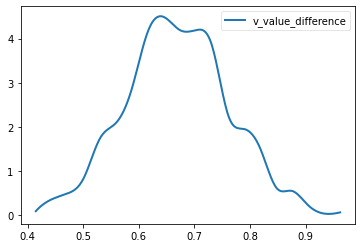

In [6]:
v_reg = m_reg2.nodes_db.node['v_value_difference']
hddm.analyze.plot_posterior_nodes([v_reg], bins=20)


In [7]:
stats = m_reg2.gen_stats()
stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a(happy),2.32823,0.11133,2.110538,2.251561,2.326304,2.405732,2.551742,0.003715
a(neutral),2.257171,0.111103,2.04098,2.179222,2.257007,2.329278,2.47578,0.003241
a(sad),2.369295,0.127835,2.12093,2.282143,2.373154,2.454853,2.620136,0.004006
a_std,0.667256,0.057465,0.56612,0.625914,0.66229,0.704948,0.790071,0.002121
a_subj(happy).202,3.239803,0.156371,2.952153,3.129761,3.238863,3.348817,3.552963,0.005843
...,...,...,...,...,...,...,...,...
v_Intercept_subj(sad).273,-0.050543,0.062276,-0.173825,-0.093176,-0.048031,-0.009704,0.070465,0.002007
v_Intercept_subj(sad).275,0.063083,0.042573,-0.01937,0.034094,0.062493,0.092217,0.145433,0.001294
v_Intercept_subj(sad).277,0.010832,0.065582,-0.116959,-0.03247,0.011611,0.053998,0.136992,0.001861
v_Intercept_subj(sad).279,-0.027308,0.057633,-0.135003,-0.066863,-0.026937,0.013443,0.087006,0.001643


In [8]:
display(stats.loc[['v_Intercept(happy)','v_Intercept(neutral)','v_Intercept(sad)','v_Intercept_std', 't(sad)','t(happy)','t(neutral)','t_std']])


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v_Intercept(happy),0.01295,0.021713,-0.025832,-0.002665,0.013126,0.027976,0.055492,0.001009
v_Intercept(neutral),-0.014865,0.023734,-0.05911,-0.031019,-0.015589,0.001344,0.03464,0.001182
v_Intercept(sad),0.011586,0.023851,-0.03418,-0.005415,0.011951,0.027276,0.058623,0.001068
v_Intercept_std,0.084736,0.014842,0.057043,0.074796,0.084237,0.094416,0.114126,0.001115
t(sad),0.725895,0.059576,0.612696,0.68567,0.725245,0.765585,0.844874,0.001827
t(happy),0.694393,0.052074,0.595437,0.659227,0.694021,0.729983,0.801591,0.001794
t(neutral),0.675001,0.055657,0.564484,0.635534,0.672629,0.711075,0.791821,0.002101
t_std,0.328364,0.029586,0.277122,0.306506,0.326708,0.347548,0.393426,0.00128


Plotting a(happy)
Plotting a(neutral)
Plotting a(sad)
Plotting t(happy)
Plotting t(neutral)
Plotting t(sad)


Text(0.0, 1.0, 'Posterior of HDDM Parameters')

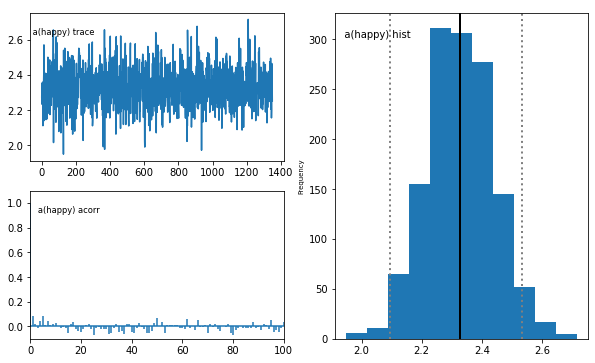

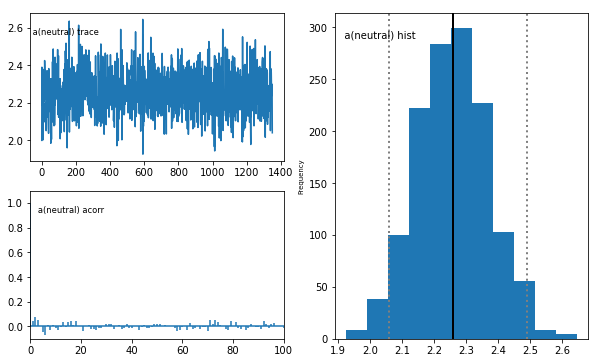

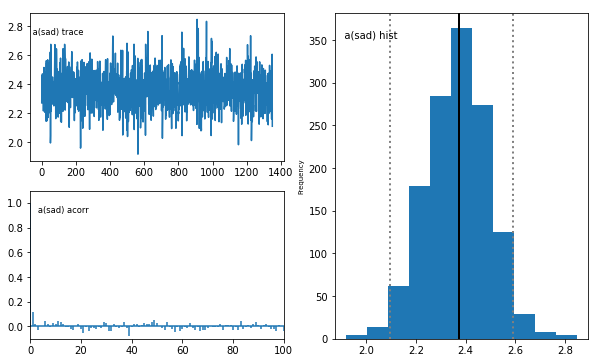

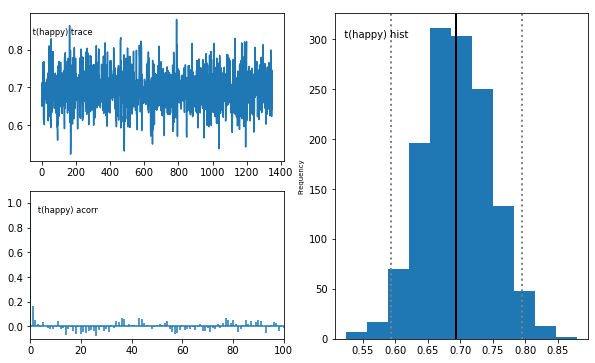

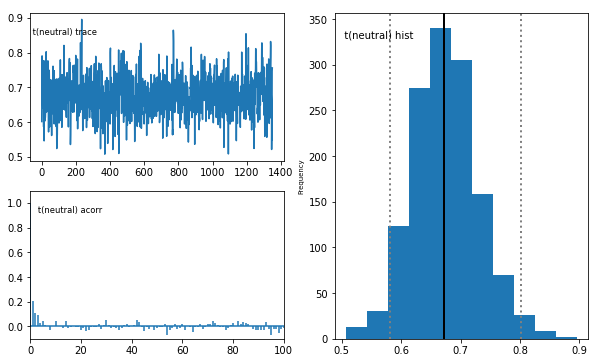

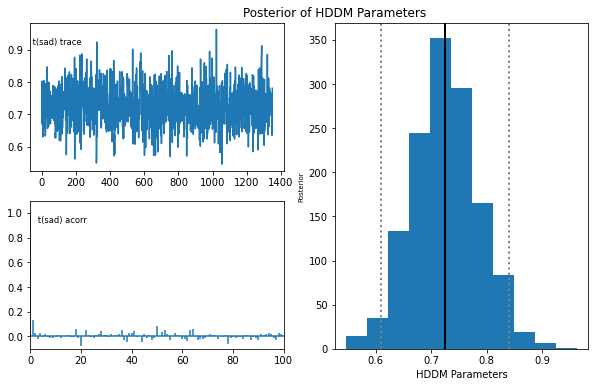

In [9]:
m_reg2.plot_posteriors(['a', 't', 'v_intercept'])

plt.xlabel('HDDM Parameters')
plt.ylabel('Posterior')
plt.title('Posterior of HDDM Parameters')

In [10]:
m_reg_lst = [m_reg2, m_reg2]
hddm.analyze.gelman_rubin(m_reg_lst)

{'a(happy)': 0.9996295610171096,
 'a(neutral)': 0.9996295610171095,
 'a(sad)': 0.9996295610171096,
 'a_std': 0.9996295610171095,
 'a_subj(happy).202': 0.9996295610171096,
 'a_subj(happy).204': 0.9996295610171095,
 'a_subj(happy).206': 0.9996295610171096,
 'a_subj(happy).208': 0.9996295610171096,
 'a_subj(happy).210': 0.9996295610171095,
 'a_subj(happy).212': 0.9996295610171096,
 'a_subj(happy).214': 0.9996295610171096,
 'a_subj(happy).216': 0.9996295610171096,
 'a_subj(happy).218': 0.9996295610171096,
 'a_subj(happy).220': 0.9996295610171095,
 'a_subj(happy).222': 0.9996295610171096,
 'a_subj(happy).224': 0.9996295610171096,
 'a_subj(happy).226': 0.9996295610171096,
 'a_subj(happy).228': 0.9996295610171096,
 'a_subj(happy).230': 0.9996295610171095,
 'a_subj(happy).234': 0.9996295610171096,
 'a_subj(happy).238': 0.9996295610171096,
 'a_subj(happy).240': 0.9996295610171095,
 'a_subj(happy).242': 0.9996295610171096,
 'a_subj(happy).244': 0.9996295610171096,
 'a_subj(happy).246': 0.9996295

In [ ]:
#convert hddm data into inference data 
ppc_data = hddm.utils.post_pred_gen(m_reg2)

 [-----------------94%---------------   ] 84 of 89 complete in 119985.8 sec

Text(0.5, 1.0, 'Posterior Predictive Plot')

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

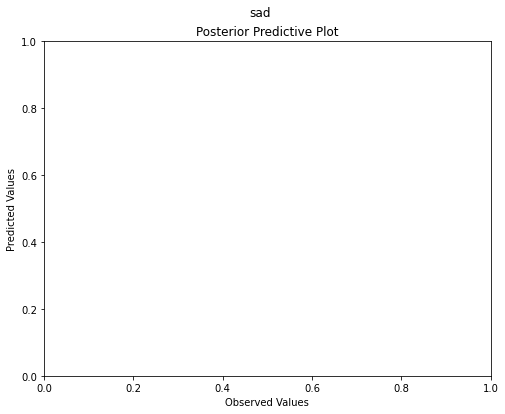

In [11]:
m_reg_lst[0].plot_posterior_predictive()

plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Posterior Predictive Plot')

In [12]:
m_comb = kabuki.utils.concat_models(m_reg_lst) # combine four chains together
m_comb.plot_posterior_predictive()

plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Combined Posterior Predictive Plot')

ValueError: db is 'ram'. Saving a model requires a database on disk.

In [13]:
print("Simple model DIC: %f" % m_reg_lst[0].dic)

Simple model DIC: 38613.241164


Text(0.5, 1.0, 'Posterior of non-decision time group means')

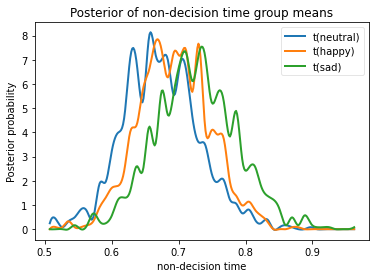

In [14]:
#how does it know which is which?
t_happy, t_sad, t_neutral = m_reg_lst[1].nodes_db.node[['t(happy)','t(sad)', 't(neutral)']]
hddm.analyze.plot_posterior_nodes([t_neutral,t_happy, t_sad])
plt.xlabel('non-decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')

Text(0.5, 1.0, 'Posterior of decision boundary group means')

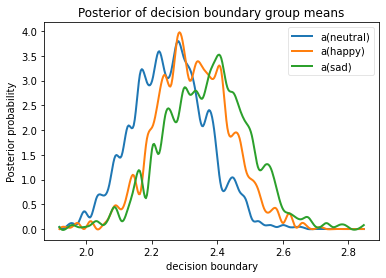

In [15]:
#how does it know which is which?
a_happy, a_sad, a_neutral = m_reg_lst[1].nodes_db.node[['a(happy)','a(sad)', 'a(neutral)']]
hddm.analyze.plot_posterior_nodes([a_neutral,a_happy, a_sad])
plt.xlabel('decision boundary')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision boundary group means')

Text(0.5, 1.0, 'Posterior of non-decision time group means')

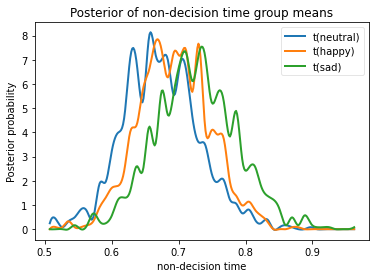

In [16]:
#how does it know which is which?
t_happy, t_sad, t_neutral = m_reg_lst[1].nodes_db.node[['t(happy)','t(sad)', 't(neutral)']]
hddm.analyze.plot_posterior_nodes([ t_neutral,t_happy, t_sad])
plt.xlabel('non-decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')

Text(0.5, 1.0, 'Posterior of non-decision time group means')

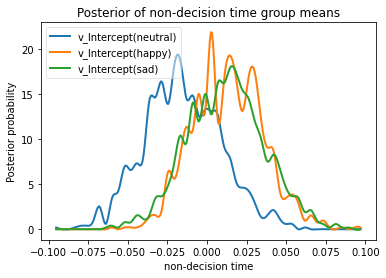

In [17]:
v_happy, v_sad, v_neutral = m_reg_lst[1].nodes_db.node[['v_Intercept(happy)','v_Intercept(sad)', 'v_Intercept(neutral)']]
hddm.analyze.plot_posterior_nodes([v_neutral, v_happy, v_sad])
plt.xlabel('non-decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')

In [18]:
#check if drift rate for happy/sad are larger than neutral - bayeasian t-test
print("P(Happy > Neutral) = ", (v_happy.trace() > v_neutral.trace()).mean())
print("P(Sad > Neutral) = ", (v_sad.trace() > v_neutral.trace()).mean())

P(Happy > Neutral) =  0.8096296296296296
P(Sad > Neutral) =  0.7888888888888889


In [19]:
#check if drift rate for happy/sad are larger than neutral - bayeasian t-test
print("P(Happy > Neutral) = ", (t_happy.trace() > t_neutral.trace()).mean())
print("P(Sad > Neutral) = ", (t_sad.trace() > t_neutral.trace()).mean())

P(Happy > Neutral) =  0.6177777777777778
P(Sad > Neutral) =  0.7459259259259259


In [20]:
#check if drift rate for happy/sad are larger than neutral - bayeasian t-test
print("P(Happy > Neutral) = ", (a_happy.trace() > a_neutral.trace()).mean())
print("P(Sad > Neutral) = ", (a_sad.trace() > a_neutral.trace()).mean())

P(Happy > Neutral) =  0.6807407407407408
P(Sad > Neutral) =  0.76


In [11]:
m_reg3 = hddm.HDDMRegressor(data,'a~value_difference')
m_reg3.sample(2000, burn=350)

Adding these covariates:
['a_Intercept', 'a_value_difference']
 [-----------------100%-----------------] 2001 of 2000 complete in 1596.0 sec

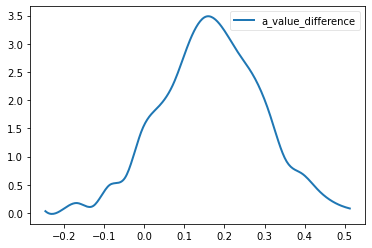

In [12]:
a_reg = m_reg3.nodes_db.node['a_value_difference']
hddm.analyze.plot_posterior_nodes([a_reg], bins=20)

In [18]:
rm3stats = m_reg3.gen_stats()
rm3stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,-0.004022,0.007876,-0.019225,-0.009303,-0.00403,0.001201,0.012025,0.000194
t,0.188392,0.007013,0.173911,0.183854,0.18846,0.193236,0.201789,0.000229
a_Intercept,2.751169,0.015088,2.721793,2.741008,2.751356,2.76138,2.780821,0.000468
a_value_difference,0.165247,0.119232,-0.066894,0.086196,0.166298,0.245178,0.402203,0.00297


In [13]:
m_reg4 = hddm.HDDMRegressor(data,'t~value_difference')
m_reg4.sample(2000, burn=350)

Adding these covariates:
['t_Intercept', 't_value_difference']
 [-----------------100%-----------------] 2001 of 2000 complete in 1396.2 sec

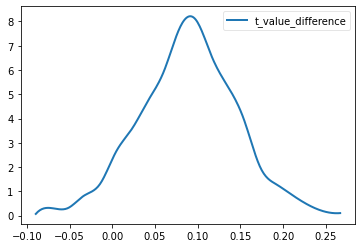

In [22]:
t_reg = m_reg4.nodes_db.node['t_value_difference']
hddm.analyze.plot_posterior_nodes([t_reg], bins=20)

In [16]:
rm4stats = m_reg4.gen_stats()
rm4stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.746559,0.01534,2.716033,2.735758,2.746866,2.756877,2.776819,0.000456
v,-0.004408,0.008032,-0.019559,-0.010136,-0.004233,0.001214,0.011126,0.000219
t_Intercept,0.190757,0.007127,0.176227,0.186121,0.190882,0.195758,0.203999,0.000221
t_value_difference,0.089073,0.053864,-0.018737,0.053469,0.089972,0.124389,0.200033,0.001331


In [20]:
m_reg5 = hddm.HDDMRegressor(data,'v~value_difference', depends_on={'v': 'Condition'})
m_reg5.sample(2000, burn=350)

Adding these covariates:
['v_Intercept', 'v_value_difference']
 [-----------------100%-----------------] 2001 of 2000 complete in 3087.8 sec

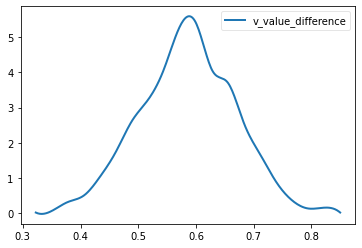

In [21]:
mvd_reg = m_reg5.nodes_db.node['v_value_difference']
hddm.analyze.plot_posterior_nodes([mvd_reg], bins=20)

In [23]:
rm5stats = m_reg5.gen_stats()
rm5stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.750012,0.015164,2.719492,2.739703,2.750359,2.76008,2.779669,0.000524
t,0.188805,0.007182,0.174552,0.183908,0.189116,0.19361,0.20278,0.00024
v_Intercept(happy),0.013996,0.012898,-0.012323,0.005897,0.013476,0.022404,0.040519,0.000311
v_Intercept(neutral),-0.011369,0.015118,-0.040549,-0.02153,-0.01159,-0.000883,0.018021,0.000379
v_Intercept(sad),0.009115,0.014659,-0.020872,-0.000688,0.008996,0.019218,0.038371,0.000352
v_value_difference,0.585175,0.078728,0.428273,0.533022,0.586601,0.639452,0.736793,0.002156


In [24]:
m_reg6 = hddm.HDDMRegressor(data,'a~value_difference', depends_on={'v': 'Condition'})
m_reg6.sample(2000, burn=350)

Adding these covariates:
['a_Intercept', 'a_value_difference']
 [-----------------100%-----------------] 2001 of 2000 complete in 1886.8 sec

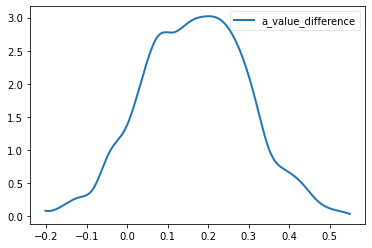

In [25]:
mvd2_reg = m_reg6.nodes_db.node['a_value_difference']
hddm.analyze.plot_posterior_nodes([mvd2_reg], bins=20)

In [26]:
rm6stats = m_reg6.gen_stats()
rm6stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v(happy),0.005473,0.012484,-0.018909,-0.003016,0.00574,0.014012,0.029438,0.00027
v(neutral),-0.021763,0.01435,-0.048865,-0.031345,-0.021661,-0.011853,0.006386,0.000339
v(sad),0.001568,0.014668,-0.026834,-0.008337,0.001434,0.011502,0.030634,0.000375
t,0.18848,0.006945,0.174497,0.183904,0.188459,0.19309,0.202287,0.000225
a_Intercept,2.751271,0.014779,2.722648,2.740608,2.751217,2.761753,2.779421,0.000471
a_value_difference,0.167735,0.122311,-0.076515,0.082921,0.170409,0.254197,0.408475,0.002853


In [27]:
m_reg7 = hddm.HDDMRegressor(data,'t~value_difference', depends_on={'v': 'Condition'})
m_reg7.sample(2000, burn=350)

Adding these covariates:
['t_Intercept', 't_value_difference']
 [-----------------100%-----------------] 2001 of 2000 complete in 1281.9 sec

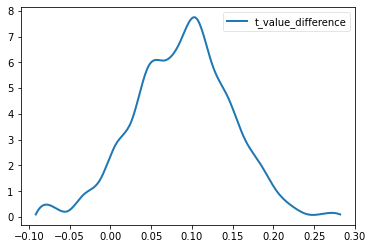

In [28]:
mvd3_reg = m_reg7.nodes_db.node['t_value_difference']
hddm.analyze.plot_posterior_nodes([mvd3_reg], bins=20)

In [29]:
rm7stats = m_reg7.gen_stats()
rm7stats

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.747483,0.014525,2.719589,2.737682,2.747312,2.756754,2.775712,0.000508
v(happy),0.004642,0.012518,-0.021012,-0.003936,0.0049,0.013274,0.028352,0.000275
v(neutral),-0.022781,0.014309,-0.050181,-0.032452,-0.022543,-0.012668,0.005369,0.00036
v(sad),0.001483,0.014609,-0.025433,-0.008681,0.001,0.011787,0.029321,0.000355
t_Intercept,0.190724,0.007059,0.176589,0.186013,0.190919,0.195786,0.203761,0.000265
t_value_difference,0.089394,0.055752,-0.024958,0.051884,0.091023,0.127568,0.192555,0.001469
